# Using Julia to Numerically Solve First-Order IVPs on Colab
> Initial version created by K. Oliveras on 6 January 2022

This Julia Notebook demonstrates how to numerically solve the initial value problem $$y' = y\left(1 - y\right), \qquad y(0) = 0.5$$ using an explicit Runge-Kutta method of order 5(4) (Dormand,Prince).


## Installing Julia on Colab
Before we get started, we need to make sure that we have Julia installed on our Colab instance.  The following code is directly taken from https://colab.research.google.com/github/ageron/julia_notebooks/blob/master/Julia_for_Pythonistas.ipynb

**In order for this to work properly, you must do the following:**
 1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
 2. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia (the Jupyter kernel for Julia) and other packages. You can update `JULIA_VERSION` and the other parameters, if you know what you're doing. Installation takes 2-3 minutes.
 3. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the _Checking the Installation_ section.

_Note_: If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2 and 3.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.6.0" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools PyCall PyPlot OrdinaryDiffEq Plots LaTeXStrings"
JULIA_PACKAGES_IF_GPU="CUDA"
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

## Refresh and Check the Installation
At this point, you will need to reload the current page.  Then, resume executing the notebook starting at this point.  

The `versioninfo()` function should print your Julia version and some other info about the system (if you ever ask for help or file an issue about Julia, you should always provide this information).

In [ ]:
versioninfo()

# Running Julia
The following block of code loads the appropriate libraries needed to 
 1. `OrdinaryDiffEq` to use a numerical ODE solver
 2. `Plots` to create pretty plots of the solution
 3. `LaTeXStrings` to use \(\LaTeX\) on the images


In [1]:
using OrdinaryDiffEq, Plots, LaTeXStrings
pyplot()

LoadError: syntax: extra token "following" after end of expression

We need to first create a differential equation function.  Since we are solving the ODE $$y' = y(1-y)$$ we will define the function `ODEFun`.  Note the format.  The arguments are in the form `ODEFun(yPrime,y,p,t)`.  The input list is as follows:
 * `yPrime`: What we plan to operate on
 * `y`: The *dependent* variable
 * `p`: A *tuple* of parameters in the differential equation.  In this case, there are no free parameters, so we don't need to use it.  However, it is *required* for the ODE solver.
 * `t`: Our *independent* variable.

In [120]:
function ODEFun(yPrime,y,p,t);
   yPrime.= y.*(1.0 .- y);
end;

Now that we have defined our differential equation, we can set the range of $t$ values we want to solve over, as well as our initial condition.  

In [121]:
tSpan = (0.0,10.0);
iniCond = [0.5];

Now that we have defined the variables, we can use `Julia`'s `ODEProblem` to define the problem we want to solve.  Then, we will use the `solve` command to numerically solve the ODE.  The following block of code
 1. creates `prob` (our initial value problem)
 2. calls `solve` to solve the IVP
 3. plots the solution 

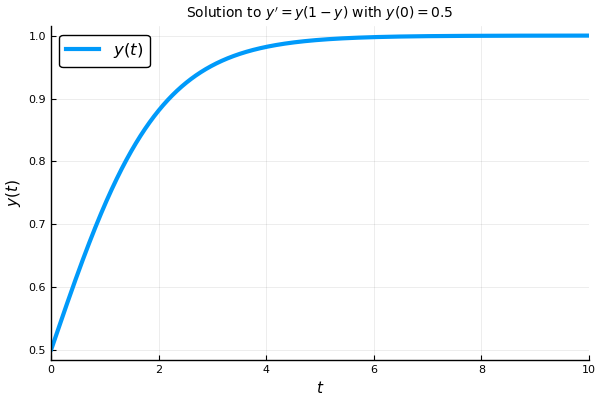

In [134]:
prob = ODEProblem(ODEFun,iniCond,tSpan);
sol = solve(prob, Tsit5(); adaptive = false, dt = 0.01);
plot(
    sol,
    xaxis=(L"$t$"),
    yaxis=(L"$y(t)$"),
    label=(L"$y(t)$"),
    legendfontsize=12,
    title=(L"Solution to $y' = y(1-y)$ with $y(0) = 0.5$"),
    titlefontsize=10)

## Plotting solutions with multiple initial conditions

Now, let's see how the solutions changes as we vary the initial conditions.  Let's create a vector of initial conditions so that $$y(0) = 0, 0.1, 0.2, \ldots 1.2$$  The command `a = collect(0.0:.1:1.2);` creates a vector `a` beginning at 0, and ending at 1.2 by taking 0.1 size steps.  The following command will generate the list of initial values we are interested in exploring.

In [116]:
a = collect(0.0:.1:1.2);
print(a)

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]

Now, we will simply pass the array of initial conditions into the definition of our `ODEProblem`.  Using the same `solve` command as before, we can also plot our solution.  Note that I set the `legend` to be `false`.  If you were to remove this command, you would have a legend entry for each initial condition.

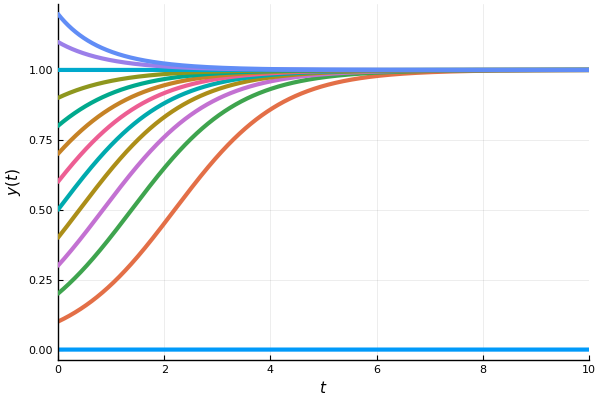

In [118]:
prob_Multiple_IniConds = ODEProblem(ODEFun,a,tSpan);
sol = solve(prob_Multiple_IniConds, Tsit5(); adaptive = false, dt = 0.01);
plot(
    sol,
    xaxis=(L"t"),
    yaxis=(L"y(t)"),
    legend=false)